In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

from itertools import cycle
from itertools import product

from googletrans import Translator

%matplotlib inline

In [2]:
#Read in .csv files into pandas dataframes
train       = pd.read_csv('sales_train.csv')
test        = pd.read_csv('test.csv').set_index('ID')
submission  = pd.read_csv('sample_submission.csv')
items       = pd.read_csv('items.csv')
item_cats   = pd.read_csv('item_categories.csv')
shops       = pd.read_csv('shops.csv')
shops_t     = pd.read_csv('shops_translated.csv')
items_t     = pd.read_csv('items_translated_text.csv')

In [3]:
#Down casts the data entries from int64 to int32 and float64 to float32
#This reduces the size of the records by almost half. (From 134mb to 61mb)
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [4]:
#Calls the downcasting function
train      = downcast_dtypes(train)
test       = downcast_dtypes(test)
submission = downcast_dtypes(submission)
items      = downcast_dtypes(items)
item_cats  = downcast_dtypes(item_cats)
shops      = downcast_dtypes(shops)
shops_t    = downcast_dtypes(shops_t)
items_t    = downcast_dtypes(items_t)

In [5]:
#adds item id to main train dataframe and drops the string name column
train = train.merge(items, on='item_id')
train = train.drop(columns = 'item_name')

In [6]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,37
1,23.01.2013,0,24,22154,999.0,1.0,37
2,20.01.2013,0,27,22154,999.0,1.0,37
3,02.01.2013,0,25,22154,999.0,1.0,37
4,03.01.2013,0,25,22154,999.0,1.0,37
...,...,...,...,...,...,...,...
2935844,17.10.2015,33,25,8428,249.0,1.0,40
2935845,01.10.2015,33,25,7903,12198.0,1.0,15
2935846,29.10.2015,33,25,7610,2890.0,1.0,64
2935847,22.10.2015,33,25,7635,2100.0,1.0,64


In [7]:
### Exploratory Merging and graphing cell for preliminary data analysis ###

# group data by month and shop_id, return sum of items sold per shop per month
month_group = pd.DataFrame(train.groupby(['date_block_num', 'shop_id'])['item_cnt_day'].sum().reset_index())

# added the item_category into sales_train
merged = pd.merge(train, items[['item_id', 'item_category_id']], on = 'item_id')

# group data by month and category_id, return sum of items sold per category per month
category_group = pd.DataFrame(merged.groupby(['date_block_num', 'item_category_id'])['item_cnt_day'].sum().reset_index())

KeyError: 'item_category_id'

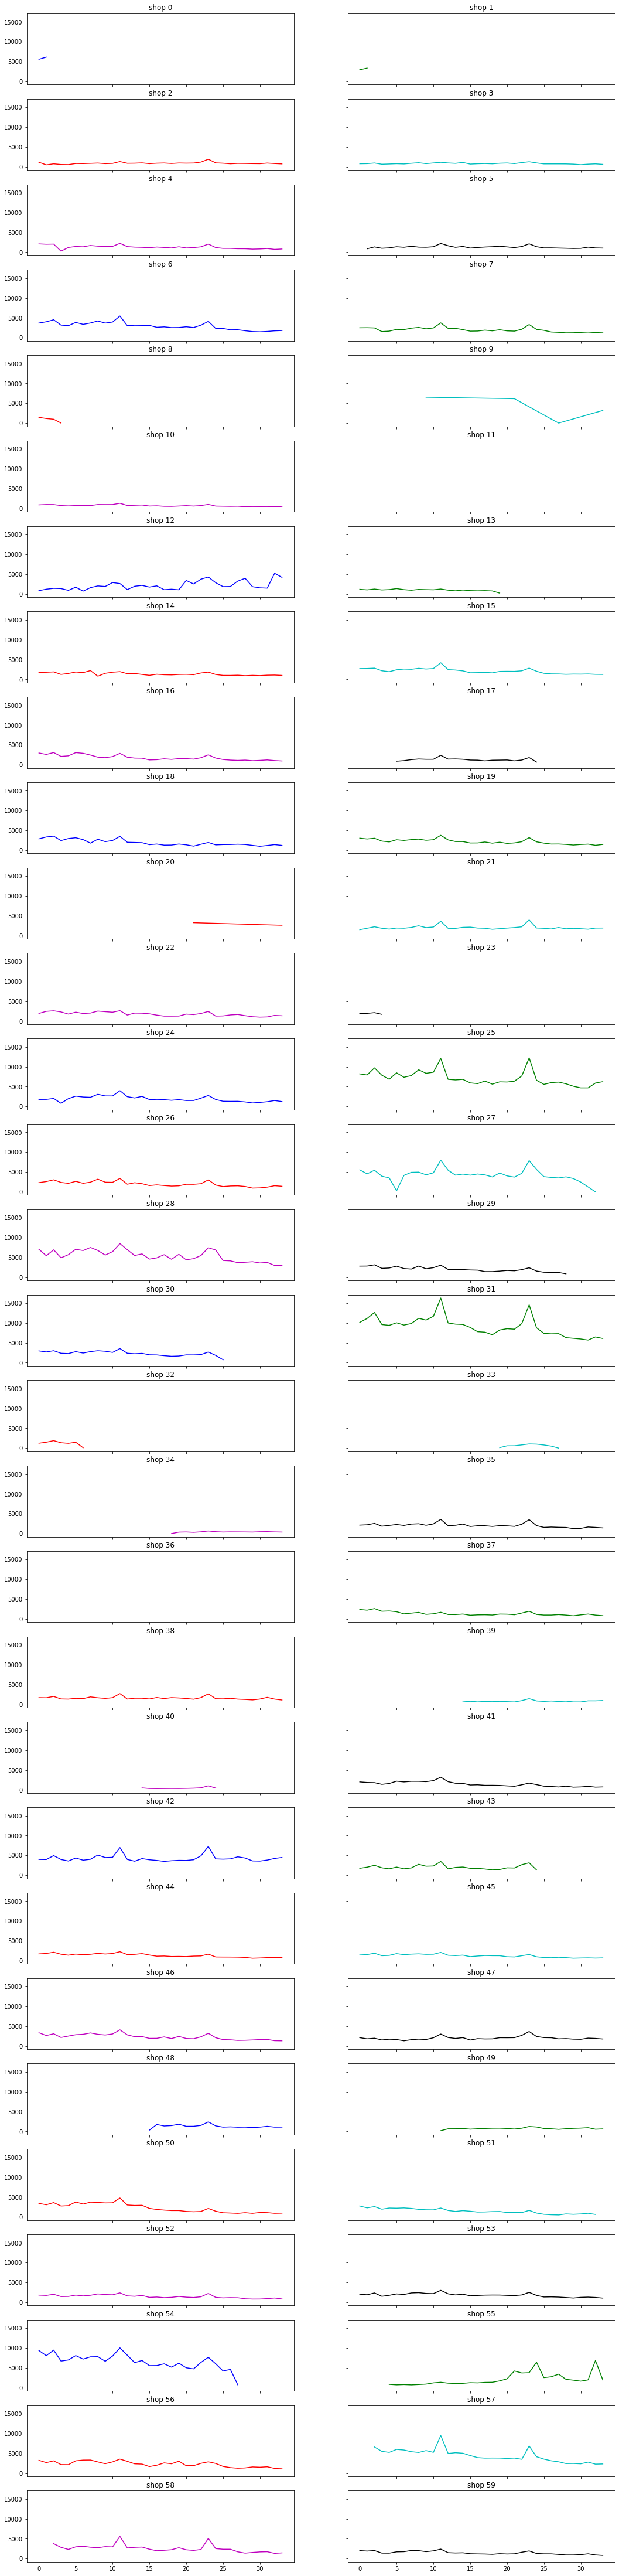

In [21]:
# plotting data for visual reference

# Plot for items sold per shop per month
fig1, axes = plt.subplots(30, 2, figsize = (18,80), sharex = True, sharey = True)
shop = 0
axis = []

for i in range(int(np.max(month_group['shop_id'])/2+1)):
    axis.append([[[],[]],[[],[]]])
    
for row in range(30):
    for col in range(2):
        for date in range(len(month_group['shop_id'])):
            if month_group['shop_id'][date] == shop:
                axis[row][col][0].append(month_group['date_block_num'][date])
                axis[row][col][1].append(month_group['item_cnt_day'][date])
        shop+=1
        
shop = 0
cycol = cycle('bgrcmk')
for row in range(30):
    for col in range(2):
        axes[row, col].plot(axis[row][col][0], axis[row][col][1], color = next(cycol))
        axes[row, col].set_title('shop ' + str(shop))
        shop += 1

NameError: name 'category_group' is not defined

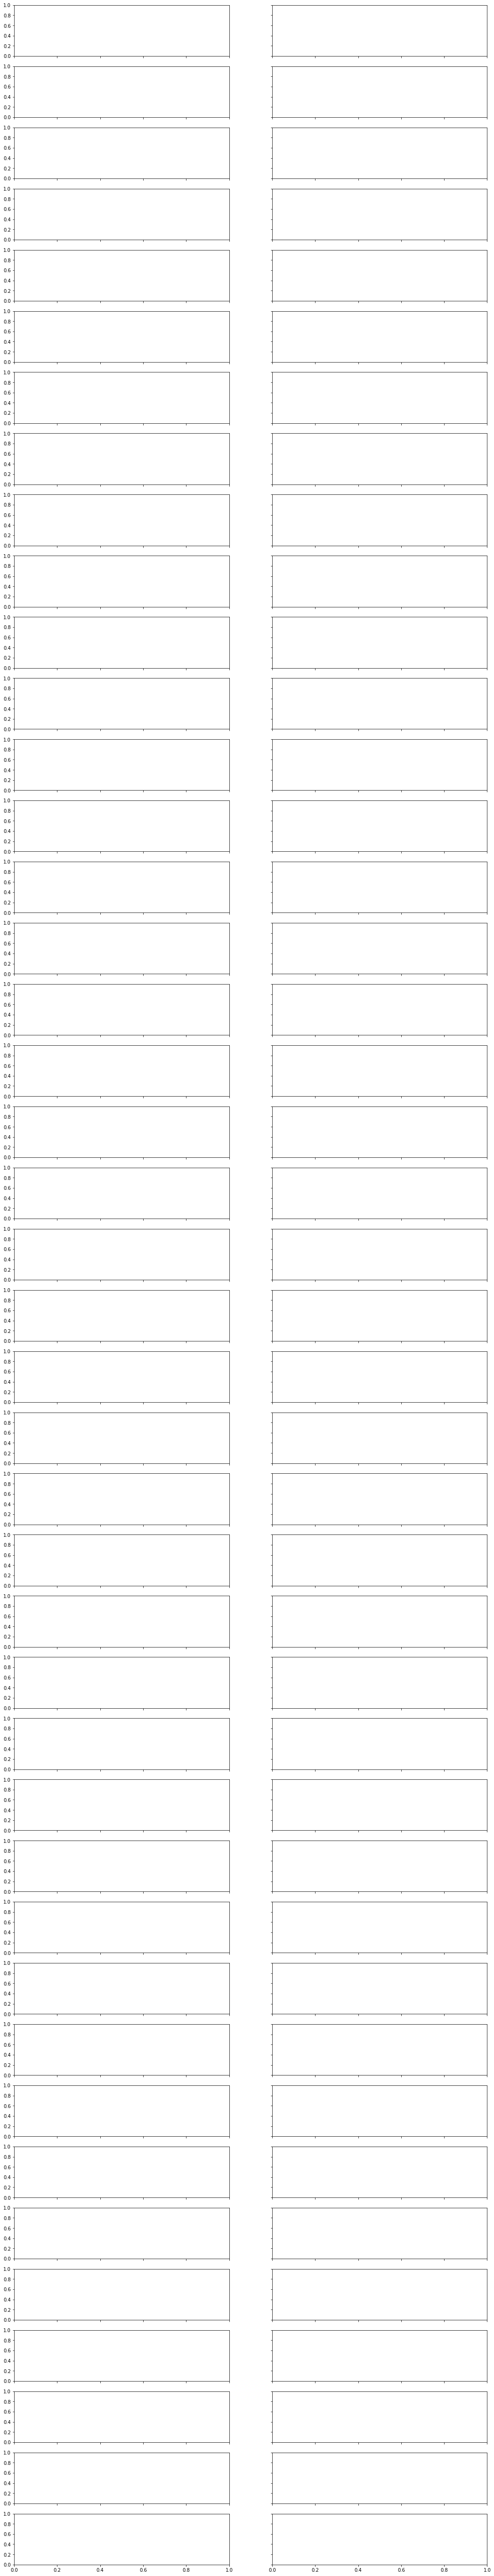

In [22]:
# plotting data for visual reference

# Plot for items sold per category per month
fig2, axes2 = plt.subplots(42, 2, figsize = (18,100), sharex = True, sharey = True)
category = 0
axis2 = []

for i in range(int(np.max(category_group['item_category_id'])/2+1)):
    axis2.append([[[],[]],[[],[]]])
    
for row in range(42):
    for col in range(2):
        for date in range(len(category_group['item_category_id'])):
            if category_group['item_category_id'][date] == category:
                axis2[row][col][0].append(category_group['date_block_num'][date])
                axis2[row][col][1].append(category_group['item_cnt_day'][date])
        category+=1
        
category = 0
cycol = cycle('bgrcmk')
for row in range(42):
    for col in range(2):
        axes2[row, col].plot(axis2[row][col][0], axis2[row][col][1], color = next(cycol))
        axes2[row, col].set_title('category ID ' + str(category))
        category += 1

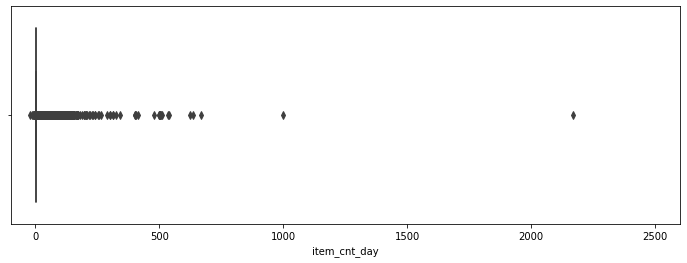

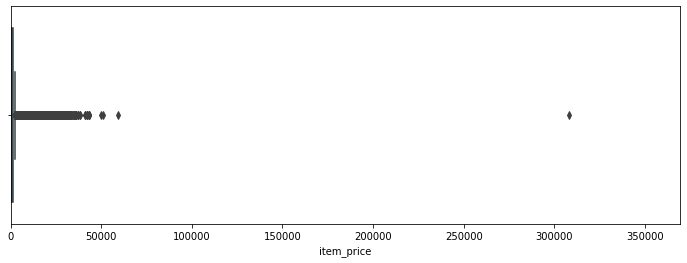

In [23]:
# Boxplot to show outliers in item_cnt_day and item_price
# This shows the outlier in price and the one instance of an unusually high sales count
plt.figure(figsize=(12,4))
plt.xlim(-100, train.item_cnt_day.max()*1.2)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(12,4))
plt.xlim(train.item_price.min()*1.1, train.item_price.max()*1.2)
sns.boxplot(x=train.item_price)

In [8]:
#Removes outliers from train
train = train[train.item_price < 90000]
train = train[train.item_cnt_day < 999]

#replaces the negative price item with the median item_price of all items with the id of 2973 and in shop id 32
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()

In [9]:
# moves item_cnt_day to the last column
train_cnt = train['item_cnt_day']
train.drop(labels=['item_cnt_day'], axis=1, inplace = True)
train.insert(6, 'item_cnt_day', train_cnt)

In [10]:
train

,date,date_block_num,shop_id,item_id,item_price,item_category_id,item_cnt_day
0,02.01.2013,0,59,22154,999.0,37,1.0
1,23.01.2013,0,24,22154,999.0,37,1.0
2,20.01.2013,0,27,22154,999.0,37,1.0
3,02.01.2013,0,25,22154,999.0,37,1.0
4,03.01.2013,0,25,22154,999.0,37,1.0
...,...,...,...,...,...,...,...
2935844,17.10.2015,33,25,8428,249.0,40,1.0
2935845,01.10.2015,33,25,7903,12198.0,15,1.0
2935846,29.10.2015,33,25,7610,2890.0,64,1.0
2935847,22.10.2015,33,25,7635,2100.0,64,1.0


In [11]:
#sums up daily sales into monthly sales in column item_cnt_day and renames it item_cnt_month

train_grouped_month = pd.DataFrame(train.groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price'])['item_cnt_day'].sum().reset_index())
train_grouped_month.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)

In [12]:
train_grouped_month

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_month
0,0,0,2,5572,1322.0,10.0
1,0,0,2,5573,560.0,1.0
2,0,0,2,5575,806.0,4.0
3,0,0,2,5576,2231.0,5.0
4,0,0,2,5609,2381.0,1.0
...,...,...,...,...,...,...
1739014,33,59,79,17717,1250.0,4.0
1739015,33,59,79,17717,1999.0,1.0
1739016,33,59,83,22087,119.0,6.0
1739017,33,59,83,22088,119.0,2.0


In [13]:
#see which shop has most values
train_grouped_month['shop_id'].value_counts().head()

31    109408
25     95955
54     75612
28     70733
57     64235
Name: shop_id, dtype: int64

In [14]:
#Create one dataframe for each shop
train_one_shop_grouped_month = train_grouped_month[train_grouped_month['shop_id'] == 31]

In [15]:
train_one_shop_grouped_month = train_one_shop_grouped_month.drop(['shop_id'], axis=1)

In [16]:
train_one_shop_grouped_month

,date_block_num,item_category_id,item_id,item_price,item_cnt_month
37386,0,2,5571,697.539978,1.0
37387,0,2,5571,699.000000,1.0
37388,0,2,5571,799.000000,1.0
37389,0,2,5572,1490.000000,1.0
37390,0,2,5572,1589.500000,1.0
...,...,...,...,...,...
1724184,33,79,17717,3084.500000,4.0
1724185,33,83,22087,119.000000,15.0
1724186,33,83,22088,119.000000,20.0
1724187,33,83,22091,179.000000,4.0


In [17]:
train_one_shop_grouped_month['date_block_num']   = [('month ' + str(i)) for i in train_one_shop_grouped_month['date_block_num']]
train_one_shop_grouped_month['item_category_id'] = [('item_category ' + str(i)) for i in train_one_shop_grouped_month['item_category_id']]
train_one_shop_grouped_month['item_id']          = [('item ' + str(i)) for i in train_one_shop_grouped_month['item_id']]

In [18]:
train_one_shop_grouped_month

,date_block_num,item_category_id,item_id,item_price,item_cnt_month
37386,month 0,item_category 2,item 5571,697.539978,1.0
37387,month 0,item_category 2,item 5571,699.000000,1.0
37388,month 0,item_category 2,item 5571,799.000000,1.0
37389,month 0,item_category 2,item 5572,1490.000000,1.0
37390,month 0,item_category 2,item 5572,1589.500000,1.0
...,...,...,...,...,...
1724184,month 33,item_category 79,item 17717,3084.500000,4.0
1724185,month 33,item_category 83,item 22087,119.000000,15.0
1724186,month 33,item_category 83,item 22088,119.000000,20.0
1724187,month 33,item_category 83,item 22091,179.000000,4.0


In [48]:
# stores all feature columns in the x variable, and stores the target variable as the last column in y variable
x = train_one_shop_grouped_month.iloc[:, :-1].values
y = train_one_shop_grouped_month.iloc[:,-1].values

In [49]:
# Encoding categorical data
# provides a value to data that can be then used in regression equations, eg. Friday = 1 etc.

ct = ColumnTransformer([('encoder', OneHotEncoder(), [0, 1, 2, 3])], remainder = 'passthrough')
x = ct.fit_transform(x)

In [51]:
# split data set into training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [52]:
# fitting multiple linear regression to the training set
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

# prediction of test split from original data, train_grouped_month
y_prediction = regressor.predict(X_test)

# The output of the this is the r squared
regressor.score(X_test, Y_test)

0.48308258374960955

In [24]:
#AUTOML CODE
#Download 64bit java
import h2o
from h2o.automl import H2OAutoML

h2o.init()
train_f1 = h2o.H2OFrame(train_one_shop_grouped_month)

splits1 = train_f1.split_frame(ratios = [0.8], seed = 1)
train_split1 = splits[0]
test_split1 = splits[1]

aml1 = H2OAutoML(max_runtime_secs = 1000, seed = 1, project_name = "sales_forecasting1")
aml1.train(y = "item_cnt_month", training_frame = train_split1, leaderboard_frame = test_split1)
lb1 = aml1.leaderboard

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,12 mins 57 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,"14 days, 17 hours and 23 minutes"
H2O_cluster_name:,H2O_from_python_Cooper_dh1j28
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.156 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |█
12:14:17.803: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Cooper\\AppData\\Local\\Temp\\tmp3pof89q9.csv'
████████████| 100%


In [25]:
lb1

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20200918_121417,56.2744,7.50163,56.2744,1.95046,nan
GBM_grid__1_AutoML_20200918_121417_model_14,56.3269,7.50513,56.3269,1.97504,nan
GBM_grid__1_AutoML_20200918_121417_model_23,56.642,7.52609,56.642,1.76857,nan
GBM_1_AutoML_20200918_121417,57.8106,7.60333,57.8106,1.92629,nan
GBM_grid__1_AutoML_20200918_121417_model_9,58.1904,7.62826,58.1904,1.89135,nan
GBM_3_AutoML_20200918_121417,58.4518,7.64538,58.4518,1.89535,nan
StackedEnsemble_AllModels_AutoML_20200918_121417,59.2478,7.69726,59.2478,1.82625,nan
GBM_grid__1_AutoML_20200918_121417_model_15,59.6376,7.72254,59.6376,1.83448,nan
GBM_grid__1_AutoML_20200918_121417_model_25,59.9411,7.74217,59.9411,1.84296,nan
GBM_2_AutoML_20200918_121417,60.8857,7.80293,60.8857,1.93182,nan


In [26]:
prediction1 = aml1.leader.model_performance(test_split1)

In [27]:
prediction1


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 56.27442094898474
RMSE: 7.501627886597998
MAE: 1.9504552664646813
RMSLE: NaN
R^2: 0.554980444019451
Mean Residual Deviance: 56.27442094898474
Null degrees of freedom: 21939
Residual degrees of freedom: 21936
Null deviance: 2774553.61476
Residual deviance: 1234660.7956207253
AIC: 150696.49056679764


In [8]:
#Translate entire csv frame of russian names into english
#Already done.
#def translate_and_save():
#    t = Translator()
#    items['english_name'] = items['item_name'].apply(lambda x: t.translate(x).text)
#    #shops['english_name'] = shops['shop_name'].apply(lambda x: t.translate(x).text)
#    items.to_csv('items_translated_text.csv')

In [40]:
# Changes numerical, categorical features into strings to properly be represented as categorical in onehotencoding
# nominal intergers can not be converted to binary encoding, convert to string
train_grouped_month['date_block_num']   = [('month ' + str(i)) for i in train_grouped_month['date_block_num']]
train_grouped_month['shop_id']          = [('shop ' + str(i)) for i in train_grouped_month['shop_id']]
train_grouped_month['item_category_id'] = [('item_category ' + str(i)) for i in train_grouped_month['item_category_id']]
train_grouped_month['item_id']          = [('item ' + str(i)) for i in train_grouped_month['item_id']]

In [41]:
train_grouped_month

,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_month
0,month 0,shop 0,item_category 2,item 5572,1322.0,10.0
1,month 0,shop 0,item_category 2,item 5573,560.0,1.0
2,month 0,shop 0,item_category 2,item 5575,806.0,4.0
3,month 0,shop 0,item_category 2,item 5576,2231.0,5.0
4,month 0,shop 0,item_category 2,item 5609,2381.0,1.0
...,...,...,...,...,...,...
1739014,month 33,shop 59,item_category 79,item 17717,1250.0,4.0
1739015,month 33,shop 59,item_category 79,item 17717,1999.0,1.0
1739016,month 33,shop 59,item_category 83,item 22087,119.0,6.0
1739017,month 33,shop 59,item_category 83,item 22088,119.0,2.0


In [11]:
# stores all feature columns in the x variable, and stores the target variable as the last column in y variable
x = train_grouped_month.iloc[:, :-1].values
y = train_grouped_month.iloc[:,-1].values

NameError: name 'train_grouped_month' is not defined

In [45]:
# Encoding categorical data
# provides a value to data that can be then used in regression equations, eg. Friday = 1 etc.

ct = ColumnTransformer([('encoder', OneHotEncoder(), [0, 1, 2, 3])], remainder = 'passthrough')
x = ct.fit_transform(x)

In [46]:
# split data set into training set and testing set
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [55]:
# fitting multiple linear regression to the training set
regressor = LinearRegression()
regressor.fit(X_train, Y_train)

# prediction of test split from original data, train_grouped_month
y_prediction = regressor.predict(X_test)

# The output of the this is the r squared
regressor.score(X_test, Y_test)

0.24532067463255935

In [48]:
# This is for playing around with different items and shops 
# sample format of test prediction = ['month 0', 'shop 0', 'item_category 2', 'item 5572', 1322]

# A simple program to see how the predictor would work

#from scipy import stats
#def auto_predictor():
#    global ct
#    month = input('Please enter the month you want to predict. Enter the digit of the month, eg. Jan = 0 : ')
#    shop = input('Please enter the shop ID, eg. 2 : ')
#    item = input("Please enter the item ID you wish to predict, eg. for item 55, enter '55' : ")
#    item_cat = (items.loc[items['item_id'] == int(item), ['item_category_id']].values)[0][0]
#    prices = train.loc[train['item_id'] == int(item), ['item_price']].values
#    price = (stats.mode(prices))[0][0][0]
    
#    z = ['month ' + str(month), 'shop ' + str(shop), 'item_category ' + str(item_cat), 'item ' + str(item), price]
#    z = np.array(z, dtype = object).reshape(1, -1)
#    z = ct.transform(z)
#    z_pred = regressor.predict(z)
    
#    return(z_pred[0])

# Things to check!!!
# ***There are multiple prices available for the item in that specific shop, provide an option to choose price

In [57]:
#AUTOML CODE
#Download 64bit java
import h2o
from h2o.automl import H2OAutoML

h2o.init()
train_f = h2o.H2OFrame(train_grouped_month)

splits = train_f.split_frame(ratios = [0.8], seed = 1)
train_split = splits[0]
test_split = splits[1]

aml = H2OAutoML(max_runtime_secs = 300, seed = 1, project_name = "sales_forecasting")
aml.train(y = "item_cnt_month", training_frame = train_split, leaderboard_frame = test_split)
lb = aml.leaderboard

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from C:\Users\Cooper\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Cooper\AppData\Local\Temp\tmp_qbiie57
  JVM stdout: C:\Users\Cooper\AppData\Local\Temp\tmp_qbiie57\h2o_Cooper_started_from_python.out
  JVM stderr: C:\Users\Cooper\AppData\Local\Temp\tmp_qbiie57\h2o_Cooper_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_Cooper_50x7e4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.547 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
17:41:02.25: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


In [60]:
#shows leaderboard of model competition
lb

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20200915_174102,26.1247,5.11123,26.1247,1.2077,nan
StackedEnsemble_BestOfFamily_AutoML_20200915_174102,28.9881,5.38406,28.9881,1.23158,nan
GBM_1_AutoML_20200915_174102,37.8056,6.14863,37.8056,1.38031,nan
GBM_2_AutoML_20200915_174102,38.6129,6.21393,38.6129,1.37153,nan
DRF_1_AutoML_20200915_174102,39.274,6.26689,39.274,1.22553,nan
GBM_4_AutoML_20200915_174102,39.3204,6.2706,39.3204,1.37281,nan
GBM_3_AutoML_20200915_174102,39.3672,6.27433,39.3672,1.37378,nan
GBM_5_AutoML_20200915_174102,49.6115,7.04354,49.6115,1.42888,nan
GLM_1_AutoML_20200915_174102,55.0418,7.41901,55.0418,1.45381,nan


In [58]:
prediction = aml.leader.model_performance(test_split)

In [59]:
prediction


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 26.124659100973304
RMSE: 5.111228727123577
MAE: 1.2077008842517318
RMSLE: NaN
R^2: 0.5454460565243231
Mean Residual Deviance: 26.124659100973304
Null degrees of freedom: 347712
Residual degrees of freedom: 347708
Null deviance: 19984172.4251989
Residual deviance: 9083883.58997673
AIC: 2121324.4241083385
